# Procesos estocásticos#

### Autor: Luis Ardévol Mesa ###

## Introducción ##

En esta práctica se pretende resolver un problema de valores iniciales suponiendo que uno de los parámetros o las condiciones iniciales siguen alguna distribución de probabilidad. En este caso, variaremos las condiciones iniciales de un péndulo doble (ya resuelto en otra práctica) siguiendo una distribución de probabilidad uniforme. 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import animation
from IPython.display import HTML

## Métodos ##

El problema planteado ya se resolvió en la práctica de problemas de valores iniciales, por lo que gran parte del código será el mismo. Esta vez usaremos solo el método de Runge Kutta mejorado, que observamos daba los mejores resultados para este caso. 

In [ ]:
#runge kutta
def rungekuta(xi, yi, f, h):
  k1 = f(xi, yi)
  k2 = f(xi + h/2, yi + h/2*k1)
  k3 = f(xi + h/2, yi + h/2*k2)
  k4 = f(xi + h, yi + h*k3)
  yi1 = yi + h/6*(k1 + 2*k2 + 2*k3 + k4)
  return yi1

#runge kutta mejorado
def rkm(x0, xf, y0, integrador, f, h, metodo):
  x, y = integrador(x0, xf, y0, f, h, metodo)
  xx, yy = integrador(x0, xf, y0, f, h/2, metodo)
  yy = yy[::2,:]
  if (len(yy[:,0]) == len(y[:, 0])):
    yymm = (y - yy*2**4)/(1 - 2**4) #Valores Runge Kutta mejorado
  else:
    y = np.delete(y, -1, 0)
    x = np.delete(x, -1)
    yymm = (y - yy*2**4)/(1 - 2**4) #Valores Runge Kutta mejorado
  return x, yymm

#Integrador de métodos de un paso
def integrador1p(x0, xf, y0, f, h, metodo):
  x = np.array([x0]) 
  y = np.matrix([y0]) #primer valor de la solucion
  while x[-1] < xf:  
    y = np.vstack([y, metodo(x[-1], y[-1], f, h)])
    x = np.append(x, x[-1] + h)
  return x, y

El problema del péndulo se define de forma análoga a la práctica anterior; dejando como parámetros la gravedad, las masas y ambas longitudes

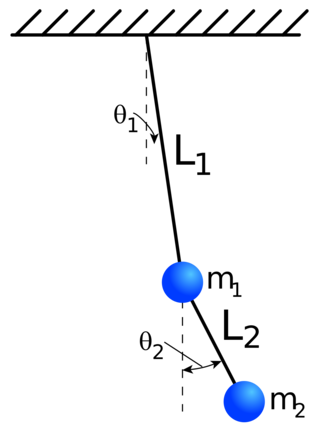

In [ ]:
class oscilador:
  """Oscilador:
     g: gravedad 
     m1 = masa del primer péndulo
     m2 = masa del segundo péndulo
     l1 = longitus del primer péndulo
     l2 = longitud del segundo péndulo
  """
  def __init__(self, g = 9.81, m1 = 1, m2 = 1, l1 = 1, l2 = 1):
    self.g = g
    self.m1 = m1
    self.m2 = m2
    self.l1 = l1
    self.l2 = l2
  def __call__(self, x, y):
    theta1 = (-self.g*(2*self.m1 + self.m2)*np.sin(y[0,0]) - self.m2*self.g*np.sin(y[0,0] - 2*y[0,1]) - 2*np.sin(y[0,0] - y[0,1])*self.m2*(y[0,3]**2*self.l2 + y[0,2]**2*self.l1*np.cos(y[0,0] - y[0,1])))/(self.l1*(2*self.m1 + self.m2 - self.m2*np.cos(2*y[0,0] - 2*y[0,1])))
    theta2 = (2*np.sin(y[0,0] - y[0,1])*(y[0,2]**2*self.l1*(self.m1 + self.m2) + self.g*(self.m1 + self.m2)*np.cos(y[0,0]) + y[0,3]**2*self.l2*self.m2*np.cos(y[0,0] - y[0,1])))/(self.l2*(2*self.m1 + self.m2 - self.m2*np.cos(2*y[0,0] - 2*y[0,1])))
    #vector y de cuatro elementos: y[0,0] e y[0,1] las posiciones, y[0,2] e y[0,3] las velocidades del primer y segundo péndulo, respectivamente
    return np.array([y[0,2], y[0,3], theta1, theta2])
  def get_longi1(self):
    return self.l1
  def get_longi2(self):
    return self.l2

Para esta práctica habrá que añadir variaciones a este problema. Para ello, definimos una clase que nos dé la opción de variar absolutamente todos los parámetros del problema si así lo queremos. Por defecto, no habrá variaciones en ninguna posición ni velocidad inicial, así como en los valores de las masas, longitudes y gravedad. \\

Definirlo de esta forma permite variar solo los parámetros que se quiera, lo que resulta muy cómodo a la hora de probar distintas variaciones y ver como se comporta el sistema frente a ellas. Ya destacamos que el sistema es muy sensible tanto a las condiciones iniciales como a sus propios parámetros, por lo que cualquier variación dará resultados muy diversos.

In [ ]:
tam = 5 #tamaño de la muestra

class variaciones:
  """
  gg = gravedad
  m11, m22 = masas 1 y 2
  l11, l22 = longitudes 1 y 2
  a1, a2 = variaciones de las posiciones iniciales de las masas 1 y 2
  v1, v2 = variaciones de las velocidades iniciales de las masas 1 y 2
  """
  def __init__(self, gg = 9.81, m11 = np.ones(tam), m22 = np.ones(tam), l11 = np.ones(tam), l22 = np.ones(tam), a1 = np.zeros(tam), a2 = np.zeros(tam), v1 = np.zeros(tam), v2 = np.zeros(tam)):
    self.gg = gg
    self.m11 = m11
    self.m22 = m22
    self.l11 = l11
    self.l22 = l22
    self.a1 = a1
    self.a2 = a2
    self.v1 = v1
    self.v2 = v2
  def __call__(self, x, t, metodo, x0, xf, integrador, h, metodoaux): #x = xx1, t = tam
    pendulodoble2 = []
    r1 = np.zeros((t, len(x))) #resultados primera masa
    r2 = np.zeros((t, len(x))) #resultados segunda masa
    for i in range(t):
      yy_00 = np.array([80 + self.a1[i], 80 + self.a2[i], 1 + self.v1[i], 1 + self.v2[i]])
      y_0 = np.array([yy_00[0]*np.pi/180, yy_00[1]*np.pi/180, yy_00[2], yy_00[3]]) #conversión de grados a radianes para operar
      pendulodoble2.append(oscilador(l1 = self.l11[i], l2 = self.l22[i], m1 = self.m11[i], m2 = self.m22[i], g = self.gg))
      yy = metodo(x0, xf, y_0, integrador, pendulodoble2[i], h, metodoaux)[1]
      for j in range(len(yy[:,0])): 
        r1[i,j] = yy[:,0][j]
        r2[i,j] = yy[:,1][j]
    return r1, r2

Se dan unas condiciones iniciales sobre las cuáles variar (en caso de querer) las mismas. Además, se define un paso lo suficientemente pequeño como para que la representación sea suave, y lo suficientemente grande como para que el tiempo de ejecución sea excesivo, ya que solo interesa comprobar que funciona y analizar las variaciones. \\

La gravedad se vaa dejar como parámetro fijo pero aleatorio. Se creará una lista con la gravedad de cada planeta del sistema Solar y, siguiendo una distribución uniforme (que solo abarque los números enteros), se seleccionará una de ellas, de modo que todos los péndulos a representar estén sometidos a la misma gravedad, pero esta puede ser aleatoria dentro de los límites establecidos.

In [ ]:
x_0 = 0.
yy_00 = np.array([80, 80, 1, 1]) #condiciones iniciales en grados y metros por segundo
y_0 = np.array([yy_00[0]*np.pi/180, yy_00[1]*np.pi/180, yy_00[2], yy_00[3]])  #conversión de grados a radianes para operar
x_fin = 25.0
h = 0.03

#gravedad aleatoria entre todos los planetas
gravedades = [3.70, 8.87, 9.81, 3.72, 24.79, 10.44, 8.87, 11.15]
grandom = np.random.randint(0, 7)
g = gravedades[grandom] 

xx1 = rkm(x_0, x_fin, y_0, integrador1p, oscilador(), h, rungekuta)[0] #para ver la cantidad de datos que habrá

Para terminar con el método, definimos la función que permitirá convertir los resultados a coordenadas cartesianas. Se define una matriz para las trayectorias de la masa 1 con todas las condiciones iniciales (primera y segunda columna para x e y con la primera condición inicial, tercera y cuarta columna para x e y con otra condición inicial, ...), y una matriz análoga para la masa 2. De este modo, toda la información del sistema queda almacenda en estas dos matrices \\

En vista de poder variar la longitud del péndulo y reflejarlo en las gráficas, se debe tener en cuenta que en el caso más geenral las longitudes son un array (si no se especifica, será un array con el mismo número en todas sus componentes, como así se refleja en la definición de la clase que lo calcula.) 

In [ ]:
def traycar(l1, l2, y1, y2): #y1 = res1; y2 = res2
  tray1 = np.zeros((len(y1[0,:]), 2*len(y1[:,0]))) #filas = longi del array de resultados para theta
  tray2 = np.zeros((len(y1[0,:]), 2*len(y1[:,0]))) #columnas = tam * 2 (x e y)
  for j in range(0, len(y1[:,0])*2, 2): #metemos en cada fila de x e y los resultados de uno y pasamos al siguiente
    for i in range(len(y1[0,:])):
      tray1[i, j] = l1[int(j/2)]*np.sin(y1[int(j/2),i]) #x_1
      tray1[i, j+1] = - l1[int(j/2)]*np.cos(y1[int(j/2),i]) #y_1
      tray2[i, j] = l2[int(j/2)]*np.sin(y2[int(j/2),i]) + l1[int(j/2)]*np.sin(y1[int(j/2),i]) #x_2
      tray2[i, j+1] = - l2[int(j/2)]*np.cos(y2[int(j/2),i]) - l1[int(j/2)]*np.cos(y1[int(j/2),i]) #y_2
  return tray1, tray2

## Resultados ##

Para el análisis de resultados definiremos variaciones de todos los parámetros posibles según una distribución uniforme e iremos viendo los resultados al variar uno o varios a la vez. Las variaciones en los ángulos será pequeñas, de 0.01 a 0.1 grados. Las velocidades iniciales podrán variar de 0.1 a 1 m/s. Para las masas se propone que puedan tomar valores desde 3 hasta 30 kilos, y las longitudes entre 0.9 y 2 metros

In [ ]:
#variaciones ángulos (en grados)
a1 = np.random.rand(tam) * 0.1 
a2 = np.random.rand(tam) * 0.1

#variaciones velocidades (en m/s)
v1 = np.random.rand(tam) * 0.1
v2 = np.random.rand(tam) * 0.1

#variaciones masas (en kilos)
m1 = np.random.rand(tam) * 30 
m2 = np.random.rand(tam) * 30

#variaciones longitudes (en metros)
l1 = np.random.uniform(0.9, 2, tam) 
l2 = np.random.uniform(0.9, 3, tam) 

Vamos a presentar los resultados en coordenadas cartesianas. Esto implica que se debe observar una trayectoria para la masa 1 sobre la circunferencia definida por su longitud (longitud 1). Estricamente no será la misma que un péndulo simple, ya que en este caso el movimiento presenta perturbaciones debido al efecto de la masa 2; sin embargo, la traza observada al final será la misma circunferencia que se tendría en el caso del péndulo simple. Para la masa 2 se debe observar una trayectoria caótica. \\

Lo mejor para ver los resultados es animarlos. Al variar levemente los parámetros, para cualquier variación de las definidas anteriormente se espera que el comportamiento de los péndulos sea similar al inicio y, antes o después, este diverja. \\

Para graficar todos a la vez, es necesario crear una lista para cada elemento a representar (líneas, masas, etc) y añadirle los objetos a los que "darle" los datos, es decir, se trabajará con listas de objetos. Ya en el bucle para animar, solo es necesario especificar los datos que debe llevar cada elemento de dichas listas. \\

Dibujaremos cada péndulo de un color distinto para diferenciarlos bien. Para ellos se define un array con 10 colores, por lo que si se quieren graficar más de 10 péndulos habría que añadir o repetir colores. No pintaremos la traza de la masa 1, ya que sabemos que es circular y ensuciaría la animación (más aún). 

### Variaciones en las posiciones iniciales ###

In [ ]:
#resultados
muestra1 = variaciones(a1 = a1, a2 = a2) #variaciones
resultados1 = muestra1(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[0]
resultados2 = muestra1(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[1]

#trayectorias en cartesianas
trayect1 = traycar(muestra1.l11, muestra1.l22, resultados1, resultados2)[0]
trayect2 = traycar(muestra1.l11, muestra1.l22, resultados1, resultados2)[1]

#grafica
fig, ax = plt.subplots(1, 2, figsize=(18,8))

limites = max(muestra1.l11) + max(muestra1.l22) + 0.5 #limites de la grafica
ax[0].set_ylim(-limites, limites)
ax[0].set_xlim(-limites, limites)

ax[1].set_ylim(-limites, limites)
ax[1].set_xlim(-limites, limites)

for i in range(0, tam*2, 2):
  ax[0].plot(trayect1[:,i],trayect1[:,i+1],'grey', alpha=0.75) #resultados masa 1
  ax[0].plot(trayect2[:,i],trayect2[:,i+1],'grey', alpha=0.35) #resultados masa 2

ax[0].grid()
ax[0].minorticks_on()


#animación 
masa1 = []
masa2 = []
linea1 = []
linea2 = []
rec = []

#negro, rojo, naranja, amarillo, verde clarito, verde oscuro, azul clarito, azul oscuro, violeta, rosa
colores = ["#000000", "#FF0000", "#FF8300", "#FFE000", "#42FF00", "#2AA000", "#00ECFF", "#001BFF", "#8F00FF", "#FF00EC"] 

for i in range(0, len(trayect1[0,:]), 2):
  masa1.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0]) #lista de objetos
  masa2.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0])
  linea1.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  linea2.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  rec.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='dashed', alpha = 0.35)[0])


def animate(i, t1, t2): 
  for j in range(0, len(t1[0,:]), 2):
    masa1[int(j/2)].set_data(t1[i,j], t1[i,j+1]) 
    masa2[int(j/2)].set_data(t2[i,j], t2[i,j+1])
    linea1[int(j/2)].set_data([0,t1[i, j]], [0, t1[i,j+1]])
    linea2[int(j/2)].set_data([t1[i, j], t2[i,j]], [t1[i, j+1], t2[i,j+1]]) #([x1, x2], [y1, y2])
    rec[int(j/2)].set_data(t2[:i,j], t2[:i,j+1])
  return masa1, masa2, linea1, linea2, rec

anim = animation.FuncAnimation(fig, animate, interval=25, frames=int(x_fin/h), fargs=[trayect1, trayect2,], repeat=False)

plt.close()
HTML(anim.to_html5_video())

### Variaciones en las velocidades iniciales ###

In [ ]:
#resultados
muestra2 = variaciones(v1 = v1, v2 = v2) #variaciones
resultados3 = muestra2(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[0]
resultados4 = muestra2(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[1]

#trayectorias en cartesianas
trayect3 = traycar(muestra2.l11, muestra2.l22, resultados3, resultados4)[0]
trayect4 = traycar(muestra2.l11, muestra2.l22, resultados3, resultados4)[1]

#grafica
fig, ax = plt.subplots(1, 2, figsize=(18,8))

limites = max(muestra2.l11) + max(muestra2.l22) + 0.5 #limites de la grafica
ax[0].set_ylim(-limites, limites)
ax[0].set_xlim(-limites, limites)

ax[1].set_ylim(-limites, limites)
ax[1].set_xlim(-limites, limites)

for i in range(0, tam*2, 2):
  ax[0].plot(trayect3[:,i],trayect3[:,i+1],'grey', alpha=0.75) #resultados masa 1
  ax[0].plot(trayect4[:,i],trayect4[:,i+1],'grey', alpha=0.35) #resultados masa 2

ax[0].grid()
ax[0].minorticks_on()


#animación 
masa1 = []
masa2 = []
linea1 = []
linea2 = []
rec = []

#negro, rojo, naranja, amarillo, verde clarito, verde oscuro, azul clarito, azul oscuro, violeta, rosa
colores = ["#000000", "#FF0000", "#FF8300", "#FFE000", "#42FF00", "#2AA000", "#00ECFF", "#001BFF", "#8F00FF", "#FF00EC"] 

for i in range(0, len(trayect3[0,:]), 2):
  masa1.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0]) #lista de objetos
  masa2.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0])
  linea1.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  linea2.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  rec.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='dashed', alpha = 0.35)[0])

anim = animation.FuncAnimation(fig, animate, interval=25, frames=int(x_fin/h), fargs=[trayect3, trayect4], repeat=False)

plt.close()
HTML(anim.to_html5_video())

### Variaciones en las masas ###

In [ ]:
#resultados
muestra3 = variaciones(m11 = m1, m22 = m2) #variaciones

resultados5 = muestra3(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[0]
resultados6 = muestra3(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[1]

#trayectorias en cartesianas
trayect5 = traycar(muestra3.l11, muestra3.l22, resultados5, resultados6)[0]
trayect6 = traycar(muestra3.l11, muestra3.l22, resultados5, resultados6)[1]

#grafica
fig, ax = plt.subplots(1, 2, figsize=(18,8))

limites = max(muestra3.l11) + max(muestra3.l22) + 0.5 #limites de la grafica
ax[0].set_ylim(-limites, limites)
ax[0].set_xlim(-limites, limites)

ax[1].set_ylim(-limites, limites)
ax[1].set_xlim(-limites, limites)

for i in range(0, tam*2, 2):
  ax[0].plot(trayect5[:,i],trayect5[:,i+1],'grey', alpha=0.75) #resultados masa 1
  ax[0].plot(trayect6[:,i],trayect6[:,i+1],'grey', alpha=0.35) #resultados masa 2

ax[0].grid()
ax[0].minorticks_on()


#animación 
masa1 = []
masa2 = []
linea1 = []
linea2 = []
rec = []

#negro, rojo, naranja, amarillo, verde clarito, verde oscuro, azul clarito, azul oscuro, violeta, rosa
colores = ["#000000", "#FF0000", "#FF8300", "#FFE000", "#42FF00", "#2AA000", "#00ECFF", "#001BFF", "#8F00FF", "#FF00EC"] 

for i in range(0, len(trayect5[0,:]), 2):
  masa1.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0]) #lista de objetos
  masa2.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0])
  linea1.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  linea2.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  rec.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='dashed', alpha = 0.35)[0])

anim = animation.FuncAnimation(fig, animate, interval=25, frames=int(x_fin/h), fargs=[trayect5, trayect6,], repeat=False)

plt.close()
HTML(anim.to_html5_video())

Output hidden; open in https://colab.research.google.com to view.

### Variaciones en las longitudes ###

In [ ]:
#resultados
muestra4 = variaciones(l11 = l1, l22 = l2) #variaciones
resultados7 = muestra4(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[0]
resultados8 = muestra4(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[1]

#trayectorias en cartesianas
trayect7 = traycar(muestra4.l11, muestra4.l22, resultados7, resultados8)[0]
trayect8 = traycar(muestra4.l11, muestra4.l22, resultados7, resultados8)[1]

#grafica
fig, ax = plt.subplots(1, 2, figsize=(18,8))

limites = max(muestra4.l11) + max(muestra4.l22) + 0.5 #limites de la grafica
ax[0].set_ylim(-limites, limites)
ax[0].set_xlim(-limites, limites)

ax[1].set_ylim(-limites, limites)
ax[1].set_xlim(-limites, limites)

for i in range(0, tam*2, 2):
  ax[0].plot(trayect7[:,i],trayect7[:,i+1],'grey', alpha=0.75) #resultados masa 1
  ax[0].plot(trayect8[:,i],trayect8[:,i+1],'grey', alpha=0.35) #resultados masa 2

ax[0].grid()
ax[0].minorticks_on()


#animación 
masa1 = []
masa2 = []
linea1 = []
linea2 = []
rec = []

#negro, rojo, naranja, amarillo, verde clarito, verde oscuro, azul clarito, azul oscuro, violeta, rosa
colores = ["#000000", "#FF0000", "#FF8300", "#FFE000", "#42FF00", "#2AA000", "#00ECFF", "#001BFF", "#8F00FF", "#FF00EC"] 

for i in range(0, len(trayect7[0,:]), 2):
  masa1.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0]) #lista de objetos
  masa2.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0])
  linea1.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  linea2.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  rec.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='dashed', alpha = 0.35)[0])

anim = animation.FuncAnimation(fig, animate, interval=25, frames=int(x_fin/h), fargs=[trayect7, trayect8,], repeat=False)

plt.close()
HTML(anim.to_html5_video())

### Variaciones en todos los parámetros (incluyendo gravedad)###

In [ ]:
#resultados
muestra5 = variaciones(gg = g, m11 = m1, m22 = m2, l11 = l1, l22 = l2, a1 = a1, a2 = a2, v1 = v1, v2 = v2) #variaciones
resultados9 = muestra5(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[0]
resultados10 = muestra5(xx1, tam, rkm, x_0, x_fin, integrador1p, h, rungekuta)[1]

#trayectorias en cartesianas
trayect9 = traycar(muestra5.l11, muestra5.l22, resultados9, resultados10)[0]
trayect10 = traycar(muestra5.l11, muestra5.l22, resultados9, resultados10)[1]

#grafica
fig, ax = plt.subplots(1, 2, figsize=(18,8))

limites = max(muestra5.l11) + max(muestra5.l22) + 0.5 #limites de la grafica
ax[0].set_ylim(-limites, limites)
ax[0].set_xlim(-limites, limites)

ax[1].set_ylim(-limites, limites)
ax[1].set_xlim(-limites, limites)

for i in range(0, tam*2, 2):
  ax[0].plot(trayect9[:,i],trayect9[:,i+1],'grey', alpha=0.75) #resultados masa 1
  ax[0].plot(trayect10[:,i],trayect10[:,i+1],'grey', alpha=0.35) #resultados masa 2

ax[0].grid()
ax[0].minorticks_on()


#animación 
masa1 = []
masa2 = []
linea1 = []
linea2 = []
rec = []

#negro, rojo, naranja, amarillo, verde clarito, verde oscuro, azul clarito, azul oscuro, violeta, rosa
colores = ["#000000", "#FF0000", "#FF8300", "#FFE000", "#42FF00", "#2AA000", "#00ECFF", "#001BFF", "#8F00FF", "#FF00EC"] 

for i in range(0, len(trayect9[0,:]), 2):
  masa1.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0]) #lista de objetos
  masa2.append(ax[1].plot([], [], color = colores[int(i/2)], marker='o', lw=2, markersize=8)[0])
  linea1.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  linea2.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='solid')[0])
  rec.append(ax[1].plot([], [], color = colores[int(i/2)], linestyle='dashed', alpha = 0.35)[0])

anim = animation.FuncAnimation(fig, animate, interval=25, frames=int(x_fin/h), fargs=[trayect9, trayect10,], repeat=False)

plt.close()
HTML(anim.to_html5_video())

## Análisis ##

In [ ]:
listapendulos = ['Primer', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', 'Sexto', 'Séptimo', 'Octavo', 'Noveno', 'Décimo']

for i in range(tam):
  print(str(listapendulos[i]) + ' péndulo: theta_1 = ' + str(yy_00[0] + np.round(a1[i], 5)) + 'º y theta_2 = ' + str(yy_00[1] + np.round(a2[i], 5)) + 'º')

Primer péndulo: theta_1 = 80.07302º y theta_2 = 80.04171º
Segundo péndulo: theta_1 = 80.06104º y theta_2 = 80.04094º
Tercero péndulo: theta_1 = 80.03801º y theta_2 = 80.03531º
Cuarto péndulo: theta_1 = 80.03652º y theta_2 = 80.04109º
Quinto péndulo: theta_1 = 80.05788º y theta_2 = 80.067º


Estas son las posiciones de los péndulos tras sufrir las variaciones propuestas. Nos fijamos que una variación en ellas tarda un tiempo en diferenciar las trayectorias de los péndulos. Tras este tiempo, como era de esperar, se tiene un comportamiento caótico para cada péndulo.

In [ ]:
for i in range(tam):
  print(str(listapendulos[i]) + ' péndulo: v1 = ' + str(yy_00[2] + np.round(v1[i], 5)) + ' m/s y v2 = ' + str(yy_00[3] + np.round(v2[i], 5)) + ' m/s')

Primer péndulo: v1 = 1.01675 m/s y v2 = 1.05263 m/s
Segundo péndulo: v1 = 1.08099 m/s y v2 = 1.0564 m/s
Tercero péndulo: v1 = 1.04291 m/s y v2 = 1.0818 m/s
Cuarto péndulo: v1 = 1.03546 m/s y v2 = 1.00711 m/s
Quinto péndulo: v1 = 1.07723 m/s y v2 = 1.09697 m/s


Estas son las velocidades de los péndulos tras sufrir las variaciones propuestas. Una variación en ellas también tarda un tiempo en diferenciar las trayectorias de los péndulos. Sin embargo, esta divergencia se produce antes que en el caso anterior. Tras este tiempo, recuperamos el comportamiento caótico. 

In [ ]:
for i in range(tam):
  print(str(listapendulos[i]) + ' péndulo: m1 = ' + str(np.round(m1[i], 2)) + ' kg y m2 = ' + str(np.round(m2[i], 2)) + ' kg')


Primer péndulo: m1 = 29.5 kg y m2 = 27.18 kg
Segundo péndulo: m1 = 13.49 kg y m2 = 20.12 kg
Tercero péndulo: m1 = 15.72 kg y m2 = 28.04 kg
Cuarto péndulo: m1 = 23.82 kg y m2 = 27.83 kg
Quinto péndulo: m1 = 17.85 kg y m2 = 9.74 kg


Estas son las masas de los péndulos, que toman valores aleatorios entre 3 y 30 kg siguiendo una distribución uniforme. Una variación en ellas diferencia el comportamiento de los péndulos desde casi el inicio de la simulación, manteniendo el compprtamiento caótico 

In [ ]:
for i in range(tam):
  print(str(listapendulos[i]) + ' péndulo: l1 = ' + str(np.round(l1[i], 3)) + ' m y l2 = ' + str(np.round(l2[i], 3)) + ' m')

Primer péndulo: l1 = 1.233 m y l2 = 2.445 m
Segundo péndulo: l1 = 1.44 m y l2 = 2.105 m
Tercero péndulo: l1 = 1.554 m y l2 = 1.985 m
Cuarto péndulo: l1 = 1.872 m y l2 = 1.157 m
Quinto péndulo: l1 = 1.312 m y l2 = 2.334 m


Estas son las longitudes de los péndulos, que toman valores aleatorios entre 0.9 y 2 metros siguiendo una distribución uniforme. Una variación en ellas también diferencia el comportamiento de los péndulos desde casi el inicio de la simulación, manteniendo el comportamiento caótico. Nótese que pese a variar desde el inicio al igual que en el caso anterior, al tratarse de un sistema caótico siguen trayectorias completamente distintas. 

In [ ]:
print('Gravedad: ' + str(g))
print()
for i in range(tam):
  print(str(listapendulos[i]) + ' péndulo: theta_1 = ' + str(yy_00[0] + np.round(a1[i], 5)) + 'º, theta_2 = ' + str(yy_00[1] + np.round(a2[i], 5)) + 'º,' + \
        ' v1 = ' + str(yy_00[2] + np.round(v1[i], 5)) + ' m/s, v2 = ' + str(yy_00[3] + np.round(v2[i], 5)) + ' m/s,' + \
        ' m1 = ' + str(np.round(m1[i], 2)) + ' kg, m2 = ' + str(np.round(m2[i], 2)) + ' kg,' + \
        ' l1 = ' + str(np.round(l1[i], 3)) + ' m, l2 = ' + str(np.round(l2[i], 3)) + ' m')

Gravedad: 3.7

Primer péndulo: theta_1 = 80.07302º, theta_2 = 80.04171º, v1 = 1.01675 m/s, v2 = 1.05263 m/s, m1 = 29.5 kg, m2 = 27.18 kg, l1 = 1.233 m, l2 = 2.445 m
Segundo péndulo: theta_1 = 80.06104º, theta_2 = 80.04094º, v1 = 1.08099 m/s, v2 = 1.0564 m/s, m1 = 13.49 kg, m2 = 20.12 kg, l1 = 1.44 m, l2 = 2.105 m
Tercero péndulo: theta_1 = 80.03801º, theta_2 = 80.03531º, v1 = 1.04291 m/s, v2 = 1.0818 m/s, m1 = 15.72 kg, m2 = 28.04 kg, l1 = 1.554 m, l2 = 1.985 m
Cuarto péndulo: theta_1 = 80.03652º, theta_2 = 80.04109º, v1 = 1.03546 m/s, v2 = 1.00711 m/s, m1 = 23.82 kg, m2 = 27.83 kg, l1 = 1.872 m, l2 = 1.157 m
Quinto péndulo: theta_1 = 80.05788º, theta_2 = 80.067º, v1 = 1.07723 m/s, v2 = 1.09697 m/s, m1 = 17.85 kg, m2 = 9.74 kg, l1 = 1.312 m, l2 = 2.334 m


Estos son lós péndulos tras variar todos los parámetros, sometidos a la gravedad que se especifica. Para una gravedad menor a la tierra, veremos un movimiento 'ralentizado' respecto al que esperaríamos con gravedad terrestre. Para gravedades ligeramente mayores, este movimiento se verá 'acelerado'. \\

Al variar todos los parámetros y condiciones iniciales, el comportamiento de los péndulos será distinto desde un principio, presentando trayectorias caóticas desde tal instánte. 